# Phase retrieval

Phase retrieval is the problem of recovering a signal $x_0 \in \mathbb{C}^n$ from the 
magnitudes of the complex inner products $x_0^* a_k$, for $k = 1, \ldots, m$, where 
$a_k \in \mathbb{C}^n$ are the given measurement vectors.  

The recovery problem can be expressed as

$$
\begin{array}{ll}
\text{find} & x \\
\text{subject to} & |x^* a_k| = y_k, \quad k = 1, \ldots, m,
\end{array}
$$

where $x \in \mathbb{C}^n$ is the optimization variable, and $a_k$ and 
$y_k \in \mathbb{R}_+$ are given. The lefthand side of the constraints are convex 
quadratic functions of the real and imaginary parts of the arguments, which are in turn 
linear functions of the variable $x$.

## Model definition

The following code segment specifies the problem.  

DCCP does not yet support complex variables and constants, so we expand complex numbers 
into real and imaginary parts.

In [1]:
"""DCCP package."""

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from dccp import is_dccp

# Set up random number generator for reproducibility
rng = np.random.default_rng(42)

n = 128
m = 3 * n

# data
x0r = rng.random((n, 1))
x0i = rng.random((n, 1))
Ar = rng.random((m, n))
Ai = rng.random((m, n))
yr = np.dot(Ar, x0r) + np.dot(Ai, x0i)
yi = np.dot(Ar, x0i) - np.dot(Ai, x0r)
y = np.power(yr, 2) + np.power(yi, 2)
y = np.power(y, 0.5)

# problem definition
xr = cp.Variable((n, 1))
xi = cp.Variable((n, 1))
x = cp.Variable((2, n))
z = []
constr = []
c = np.array([[0, 1], [-1, 0]])

for k in range(m):
    z.append(cp.Variable((2, 1)))
    z[-1].value = -rng.random((2, 1))
    constr.append(cp.norm(z[-1]) == y[k])
    constr += [
        z[-1] == x @ np.reshape(Ar[k, :], (n, 1)) + c @ x @ np.reshape(Ai[k, :], (n, 1))
    ]

# solve the problem
prob = cp.Problem(cp.Minimize(0), constr)
assert is_dccp(prob)
result = prob.solve(method="dccp", seed=0)
assert prob.status == cp.OPTIMAL
assert result is not None

## Visualize the results

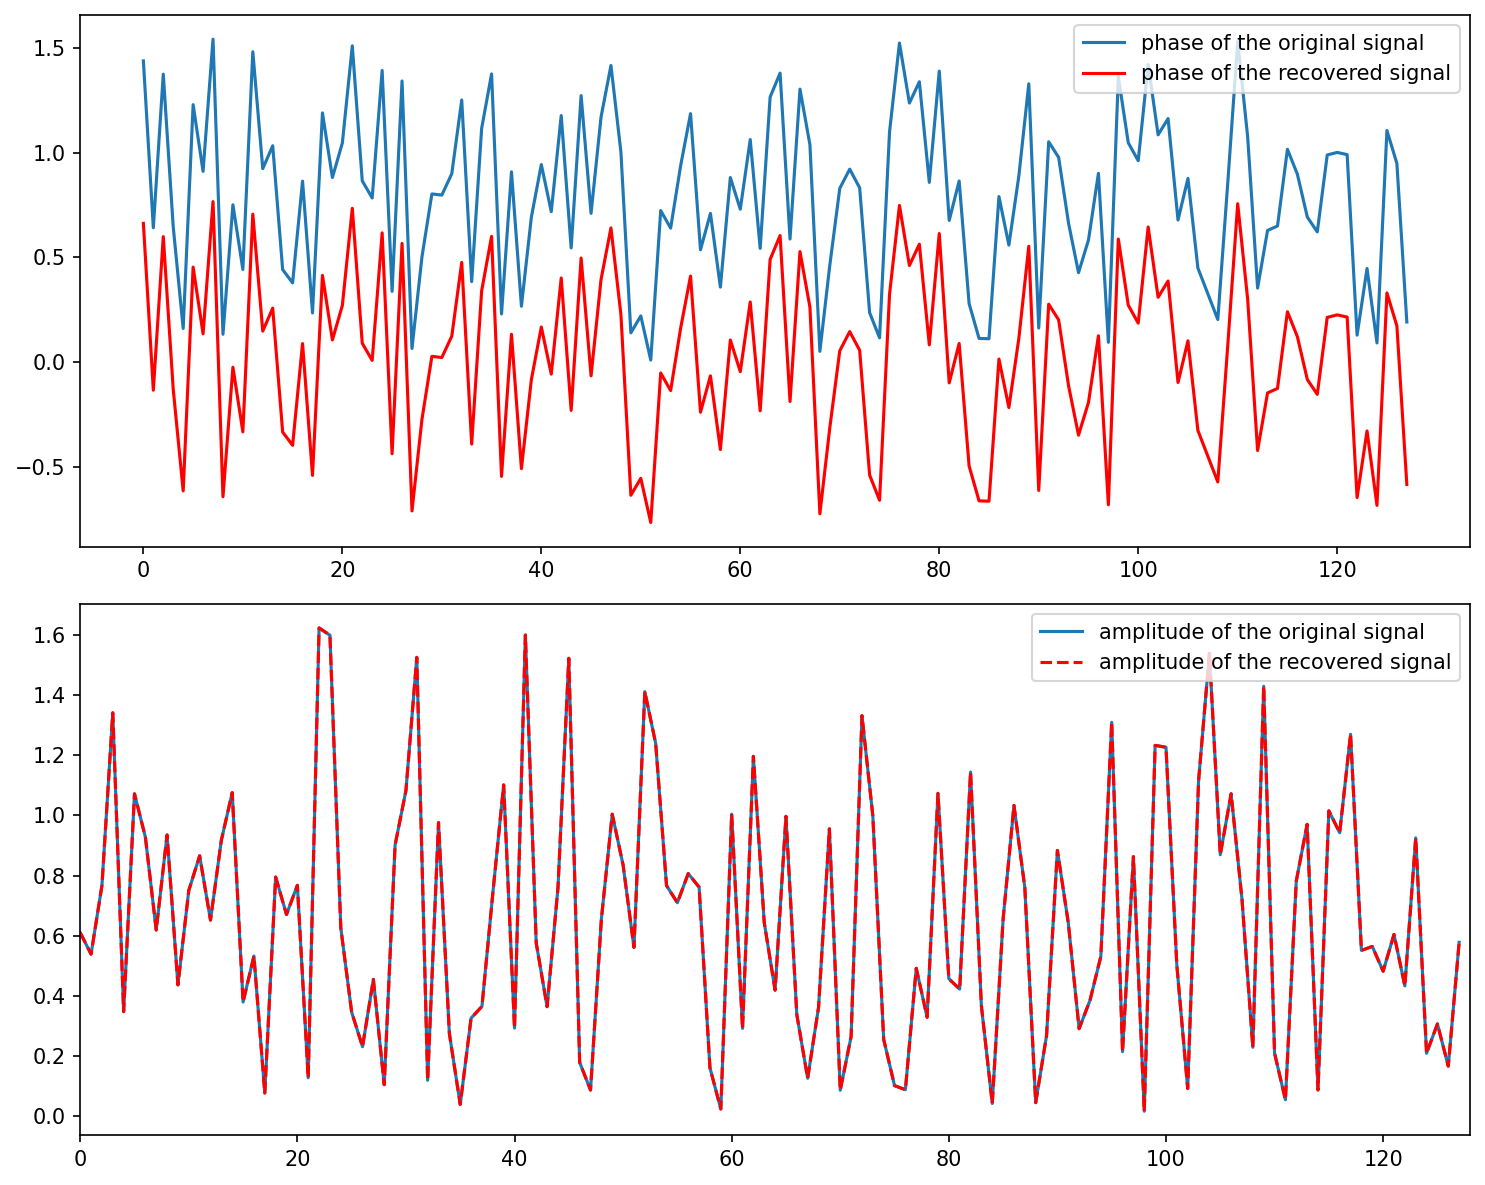

In [2]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 8), dpi=150)
tan = np.array(x[0, :].value / x[1, :].value)
angle = np.arctan(tan)
tan0 = x0r / x0i
angle0 = np.arctan(tan0)
ax0.plot(angle0)
ax0.plot(angle, "r")
plt.xlim([0, 128])
ax0.legend(["phase of the original signal", "phase of the recovered signal"])
ax1.plot(np.array(np.power(x0r, 2) + np.power(x0i, 2)))
ax1.plot(np.array(np.power(x[0, :].value, 2) + np.power(x[1, :].value, 2)), "r--")
plt.xlim([0, 128])
ax1.legend(["amplitude of the original signal", "amplitude of the recovered signal"])
plt.tight_layout()